---
title: "Modeling Coronavirus Infections"
subtitle: "BMES 678 Course Project"
author: "Team 2: Tony K. Okeke, Gabriella Grym, Grace Fan"
format: PrettyPDF-pdf
---

Implement the basic SEIR model and the network-based simulation described below. Your implementation and analysis do not need to be limited to these instructions. You are encouraged to do your own literature research of alternative models.

Here are some of the metrics you can use to compare the results of the SEIR model and the network model:

- Date of peak # infections and # of peak infections
- Total # infections over 1 year.
- Total # deaths (if death is being modeled) over 1 year.
- Peak # hospitalizations (if hospitalizations are modeled).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display_html, HTML
from scipy import sparse
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np

import gc

import tools

np.random.seed(42)

## Basic Model: COVID SEIR [Milestone 1]

Implement and simulate the SEIR model of Coronavirus infections described in [The effectiveness of quarantine of Wuhan city against the Corona Virus Disease 2019 (COVID-19): A well-mixed SEIR model analysis](https://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:sim2:proj:Hou2020.covid.seirmodel.pdf). Use model parameters as provided in the paper (no parameter estimation involved). Replicate Figure 2 (your x axis may show number of days, rather than specific dates) and Table 2 of the article.

Correction: beta1 and beta2 parameters do not appear to be correctly listed in Table1 of the paper. Use `beta1=0.04` and `beta2=0.02` instead.


The equations and diagram below describe the Susceptible-Exposed-Infectious-Recovered (SEIR) model for COVID infections:

\begin{align}
\frac{dS}{dt} &= -\frac{S}{N} \left(r_1 \beta_1  I + r_2 \beta_2 E \right) \\
\frac{dE}{dt} &= \frac{S}{N}\left( r_1 \beta_1 I + r_2 \beta_2 E \right) - \alpha E \\
\frac{dI}{dt} &= \alpha E - \gamma I \\
\frac{dR}{dt} &= \gamma I 
\end{align}

```{mermaid}
%%| fig-width: 7
%%| fig-align: center

graph LR
    S[Susceptible] -->|r1| CI[Contacted\nInfected]
    S -->|r2| CE[Contacted\nExposed]
    CI -->|beta1| E[Exposed]
    CE -->|beta2| E
    E -->|alpha| I[Infected]
    I -->|gamma| R[Recovered]
```

In [3]:
def basic_model(t, Y, params):
    """System of ODEs for the SEIR model."""
    N, beta1, beta2, alpha, gamma, r1, r2 = params
    S, E, I, R = Y
    dS = -S / N * (r1 * beta1 * I + r2 * beta2 * E)
    dE = S / N * (r1 * beta1 * I + r2 * beta2 * E) - alpha * E
    dI = alpha * E - gamma * I
    dR = gamma * I

    return np.array([dS, dE, dI, dR])


def run_basic_model(params, replicate=True):
    """Simulate the basic SEIR model."""
    if replicate:
        Y0 = [11_080_778, 193, 27, 2]  # S, E, I, R
        N = 11_081_000
    else:
        Y0 = [9_778, 193, 27, 2]  # S, E, I, R
        N = 10_000
    tspan = (0, 200)

    beta1, beta2, alpha, gamma, r1, r2 = params
    full_params = [N, beta1, beta2, alpha, gamma, r1, r2]
    T, Y = tools.rk4(lambda t, Y: basic_model(t, Y, full_params), tspan, Y0, 0.1)
    return T, Y

Running simulations: 100%|██████████| 13/13 [00:00<00:00, 13.17it/s]


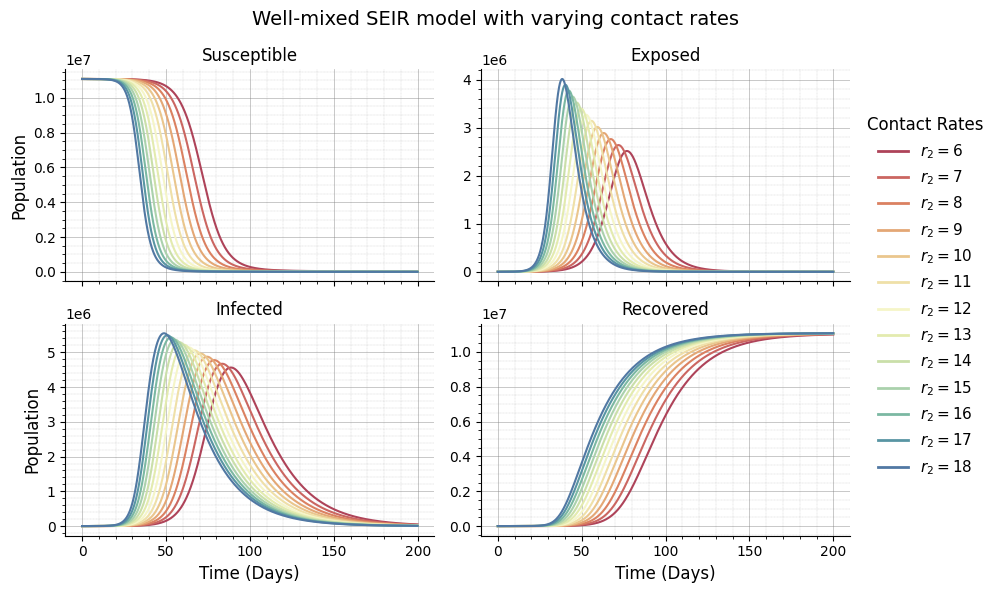

In [4]:
# | fig-align: center
# | fig-cap: Well-mixed SEIR model with varying contact rates. Replicating Figure 2 of the paper.

# define simulation parameters
params = [0.04, 0.02, 0.14, 0.048, 6, 6] # beta1, beta2, alpha, gamma, r1, r2

# define iterables
r2_values = np.arange(6, 19, 1)
colors = sns.color_palette("Spectral", len(r2_values), desat=0.7).as_hex()
labels = [f"$r_2 = {r2}$" for r2 in r2_values]

# keep track of infection peaks
infection_peaks = []

# run simulations and plot results
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Well-mixed SEIR model with varying contact rates", fontsize=14)

with tqdm(total=len(r2_values), desc="Running simulations") as pbar:
    for i, (r2, c) in enumerate(zip(r2_values, colors)):
        params[-1] = r2
        T, Y = run_basic_model(params)

        # store infection peak
        infection_peaks.append(T[Y[:, 2].argmax()])

        for j, (ax, title) in enumerate(
            zip(axes.flat, ["Susceptible", "Exposed", "Infected", "Recovered"])
        ):
            if i == 0:
                tools.style_axis(ax)
                ax.set_title(title, fontsize=12)
                if j in [0, 2]:
                    ax.set_ylabel("Population", fontsize=12)
                if j in [2, 3]:
                    ax.set_xlabel("Time (Days)", fontsize=12)

            ax.plot(T, Y[:, j], color=c)

        pbar.update(1)

# prepare legend
fig.legend(
    [plt.Line2D([0], [0], color=c, lw=2) for c in colors],
    labels,
    loc="center right",
    fontsize=11,
    title="Contact Rates",
    title_fontsize=12,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 0.87, 1])
plt.savefig("figures/milestone-1-replicate-infection_peaks.png", dpi=300)

In [5]:
# | tbl-cap: Infection peaks for varying contact rates

# create table of results
start_date = dt.date(2020, 1, 1)
peak_times = [start_date + dt.timedelta(days=d) for d in infection_peaks]

df = pd.DataFrame(
    data={"Contact rate of latent individuals": r2_values, "Peak time": peak_times}
)
display_html(HTML(df.to_html(index=False)))

Contact rate of latent individuals 
 Peak time 
 
 
 
 
 6 
 2020-03-29 
 
 
 7 
 2020-03-24 
 
 
 8 
 2020-03-19 
 
 
 9 
 2020-03-15 
 
 
 10 
 2020-03-11 
 
 
 11 
 2020-03-07 
 
 
 12 
 2020-03-04 
 
 
 13 
 2020-03-01 
 
 
 14 
 2020-02-27 
 
 
 15 
 2020-02-25 
 
 
 16 
 2020-02-22 
 
 
 17 
 2020-02-20 
 
 
 18 
 2020-02-18

In [6]:
#| fig-align: center
#| fig-cap: Population dynamics for a SEIR model of a 10k population

# run basic model with population of 10k
params = [0.04, 0.02, 0.14, 0.048, 6, 6]
T_basic, Y_basic = run_basic_model(params, False)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
tools.style_axis(ax)
ax.set_ylabel("Population", fontsize=12)
ax.set_xlabel("Time (Days)", fontsize=12)

ax.plot(T_basic, Y_basic[:, 0], color='blue', label='Susceptible')
ax.plot(T_basic, Y_basic[:, 1], color='orange', label='Exposed')
ax.plot(T_basic, Y_basic[:, 2], color='green', label='Infected')
ax.plot(T_basic, Y_basic[:, 3], color='red', label='Recovered')
ax.legend(loc='best', fancybox=False)

plt.tight_layout()

plt.savefig("figures/milestone-1-population_dynamics.png", dpi=300)

## COVID Network Model [Milestone 2]

* You may work on a more complex network implementation, but for this milestone, the minimum requirement is that you have a network representation and simulate the progress of an infection.

* Possible network representation: Use a symmetric logical matrix to represent the contacts among people. In your final project, you may explore the dynamic nature of this network (ie., individuals self-quarantine when they are infected, exposed, and/or based on public policy). For this milestone, you may use a static network that does not change throughout the simulation. You may generate a random network or hard-code an example network.

* Use a vector to represent the starting state of each individual. You may come up with a numerical encoding (e.g., 0 to represent Susceptible, 1 to represent infected, etc.) or use a character-encoding (e.g., 'S', 'I') for the state of each individual. The minimum requirement for this milestone is to represent Susceptible and Infected.

* Using a for loop, simulate the system over many days.

* In each day:
    * Consider the individuals who are in contact. Let the Infected individuals turn the Susceptible individuals they are in contact with, with a certain a probability (use similar parameters as the well-mixed SEIR model to represent this infectivity.)
    
    * Turn Infected individuals to Susceptible with a certain probability. (In your final project, you may also record the time of infection and turn back to Susceptible based on a distribution that reflects the average recovery time, and also represent Recovered individuals as having an immunity that increases over time).

* Plot the number of infected individuals over the course of the simulation. If the simulation converges quickly, you may crop the time span to better show the phase until convergence.

* Submit a pdf report of your work for this milestone.


Our contact network model includes the following parameters (based on work by Hou et. al.):
- $\beta1$ - probability of infection after contact with infected individual
- $\beta2$ - probability of infection after contact with exposed individual
- $\alpha$ - rate of latent individuals becoming infectious
- $\gamma$ - recovery rate

In [7]:
def initialize_network(n):
    """Initialize network as a sparse adjacency matrix"""
    network = sparse.lil_matrix((n, n), dtype=int)
    rows, cols = np.triu_indices(n, k=1)
    data = np.random.randint(0, 2, size=len(rows))  #  random connections
    network[rows, cols] = data
    network = network + network.T  # fill in the lower triangle
    network = network.tocsr()
    return network


def initialize_states(n):
    """Initialize states with a random infection"""
    states = np.array(['S']*n)
    infection = np.random.randint(n)
    states[infection] = 'I'
    return states


def run_network_model(initial_states, network, params):
    """Simulate the network-based SEIR model."""
    beta1, beta2, alpha, gamma = params
    tspan = 200
    n = network.shape[0]
    states = initial_states.copy()
    S_count, E_count, I_count, R_count = [], [], [], []

    for day in range(tspan):
        new_states = states.copy()
        S_num, E_num, I_num, R_num = (states == 'S').sum(), (states == 'E').sum(), (states == 'I').sum(), (states == 'R').sum()

        # iterate over individuals
        for individual in range(n):
            # check if they are susceptible
            if states[individual] == 'S':
                # find all contacts
                contacts = network[individual].indices

                # check for infected and exposed contacts
                infected_contacts = states[contacts] == 'I'
                exposed_contacts = states[contacts] == 'E'

                if np.any(np.random.rand(infected_contacts.sum()) < beta1):
                    # infected by infected contact
                    new_states[individual] = 'E'
                elif np.any(np.random.rand(exposed_contacts.sum()) < beta2):
                    # infected by exposed contact
                    new_states[individual] = 'E'

            elif states[individual] == 'E' and np.random.rand() < alpha:
                # turn exposed to infected
                new_states[individual] = 'I'

            elif states[individual] == 'I' and np.random.rand() < gamma:
                # turn infected to recovered
                new_states[individual] = 'R'

        states = new_states
        S_count.append(S_num)
        E_count.append(E_num)
        I_count.append(I_num)
        R_count.append(R_num)

    t = np.arange(tspan)
    Y = np.array([S_count, E_count, I_count, R_count])

    del network
    gc.collect()
    
    return t, Y.T


# initialize parameters for network model
params = [0.04, 0.02, 0.14, 0.048]  # beta1, beta2, alpha, gamma
N = 10_000
network = initialize_network(N)
init_states = initialize_states(N)

In [15]:
#| fig-align: center
#| fig-cap: Population dynamics for a contact network of a 10k population

T_network, Y_network = run_network_model(init_states, network, params)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
tools.style_axis(ax)
ax.set_ylabel("Population", fontsize=12)
ax.set_xlabel("Time (Days)", fontsize=12)

ax.plot(T_network, Y_network[:, 0], color='blue', label='Susceptible')
ax.plot(T_network, Y_network[:, 1], color='orange', label='Exposed')
ax.plot(T_network, Y_network[:, 2], color='green', label='Infected')
ax.plot(T_network, Y_network[:, 3], color='red', label='Recovered')
ax.legend(loc='best', fancybox=False)

plt.tight_layout()
plt.savefig("figures/milestone-2-population_dynamics.png", dpi=300)



### Comparison with Basic Model

In [22]:
#| fig-align: center
#| fig-cap: Comparison of basic and network model

fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
tools.style_axis(ax)
# ax.set_ylabel("Population", fontsize=12)
# ax.set_xlabel("Time (Days)", fontsize=12)

for i, (ax, (c, title)) in enumerate(zip(
    axes.flat, zip(
        ['blue', 'orange', 'green', 'red'], 
        ['Susceptible', 'Exposed', 'Infected', 'Recovered']
    )
)):
    tools.style_axis(ax)
    ax.set_title(title, fontsize=12)

    ax.plot(T_network, Y_network[:, i], linestyle='-', color=c, label="network")
    ax.plot(T_basic, Y_basic[:, i], linestyle='--', color=c, label="basic")

    ax.legend(loc='best', fancybox=False)

    if i in [0, 2]:
        ax.set_ylabel("Population", fontsize=12)
    if i in [2, 3]:
        ax.set_xlabel("Time (Days)", fontsize=12)


plt.tight_layout()
plt.savefig("figures/milestone-2-comparison.png", dpi=300)



## Model Analysis

### Sensitivity Analysis

To understand the dynamics of these models, we will perform a sensitivity analysis. To do this, we will perturb each parameter with a 50% increment and a 50% decrement. The resulting % change to the time-to-peak and the peak populations will be reported for each of 'Susceptible', 'Exposed', 'Infected', and 'Recovered'.

#### Basic Model

In [14]:
#| fig-align: center
#| fig-cap: Sensitivity analysis for the basic model

# initialize parameters for basic model
basic_pnames = [r'$\beta_1$', r'$\beta_2$', r'$\alpha$', r'$\gamma$', r'$r_1$', r'$r_2$']
basic_params = [0.04, 0.02, 0.14, 0.048, 6, 6]

# run sensitivity analysis for basic model
basic_results = tools.run_sensitivity_analysis(
    run_basic_model, basic_params, basic_pnames
)
tools.plot_sensitivity_results(basic_results, basic_pnames)
plt.savefig("figures/sensitivity_analysis-basic_model.png", dpi=300)

--- running with $\beta_1$ perturbed by 50.0%
--- running with $\beta_1$ perturbed by -50.0%
--- running with $\beta_2$ perturbed by 50.0%
--- running with $\beta_2$ perturbed by -50.0%
--- running with $\alpha$ perturbed by 50.0%
--- running with $\alpha$ perturbed by -50.0%
--- running with $\gamma$ perturbed by 50.0%
--- running with $\gamma$ perturbed by -50.0%
--- running with $r_1$ perturbed by 50.0%
--- running with $r_1$ perturbed by -50.0%
--- running with $r_2$ perturbed by 50.0%
--- running with $r_2$ perturbed by -50.0%


#### Contact Network Model

--- running with $\beta_1$ perturbed by 50.0%
--- running with $\beta_1$ perturbed by -50.0%
--- running with $\beta_2$ perturbed by 50.0%
--- running with $\beta_2$ perturbed by -50.0%
--- running with $\alpha$ perturbed by 50.0%
--- running with $\alpha$ perturbed by -50.0%
--- running with $\gamma$ perturbed by 50.0%
--- running with $\gamma$ perturbed by -50.0%


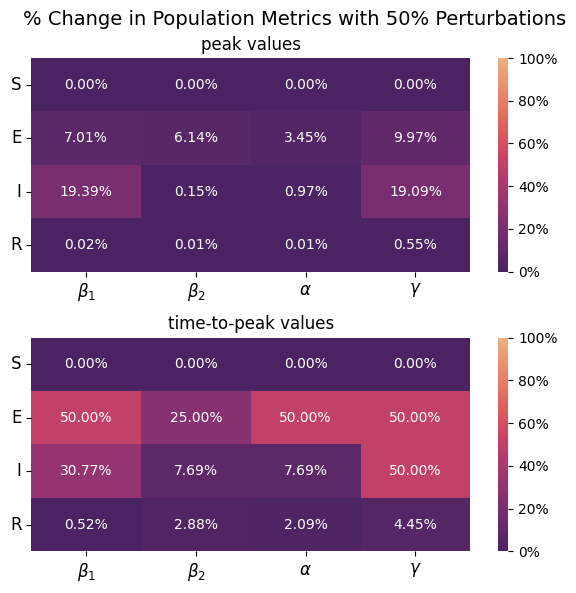

In [15]:
#| fig-align: center
#| fig-cap: Sensitivity analysis for the contact network model

# initialize parameters for network model
network_pnames = [r'$\beta_1$', r'$\beta_2$', r'$\alpha$', r'$\gamma$']
network_params = [0.04, 0.02, 0.14, 0.048]
N = 10_000
network = initialize_network(N)
init_states = initialize_states(N)

# run sensitivity analysis for network model
network_results = tools.run_sensitivity_analysis(
    lambda params: run_network_model(init_states, network, params), 
    network_params, 
    network_pnames
)
tools.plot_sensitivity_results(network_results, network_pnames)
plt.savefig("figures/sensitivity_analysis-network_model.png", dpi=300)